# Identify Contrails with Keras

In [1]:
# reinstall tensorflow-io
# to avoid the UserWarning: unable to load libtensorflow_io_plugins.so

#!pip install tensorflow-io

In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pathlib
import random

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tensorflow import keras

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# This notebook is inspired by:

# Visualization:
# - https://www.kaggle.com/code/inversion/visualizing-contrails
# - https://www.kaggle.com/code/pranavnadimpali/comprehensive-eda-submission

# Models:
# - https://keras.io/examples/vision/oxford_pets_image_segmentation/
# - https://www.kaggle.com/code/shashwatraman/simple-unet-baseline-train-lb-0-580

In [3]:
#---------------------------------------------------------------------------79

## Setup

In [5]:
class ABI:
    bands = {name: idx for idx, name in enumerate([
        '08', '09', '10', '11', '12', '13', '14', '15', '16'])}
    colors = {name: idx for idx, name in enumerate([
        'red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black'])}

In [4]:
DATA_DIR = '/kaggle/input/google-research-identify-contrails-reduce-global-warming'

class Paths:
    train = os.path.join(DATA_DIR, 'train')
    valid = os.path.join(DATA_DIR, 'validation')


In [8]:
class Config:

    train = True
    
    num_epochs = 10
    num_classes = 1
    batch_size = 32
    seed = 42
    

In [9]:
# https://keras.io/examples/keras_recipes/reproducibility_recipes/

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) `tensorflow` random seed
# 3) `python` random seed
keras.utils.set_random_seed(Config.seed)

# See also:
# tf.config.experimental.enable_op_determinism()

## Data Analysis and Visualization

In [21]:
train_ids = os.listdir(Paths.train)
valid_ids = os.listdir(Paths.valid)
print(len(train_ids), len(valid_ids))

20529 1856


In [22]:
sample_ids = train_ids

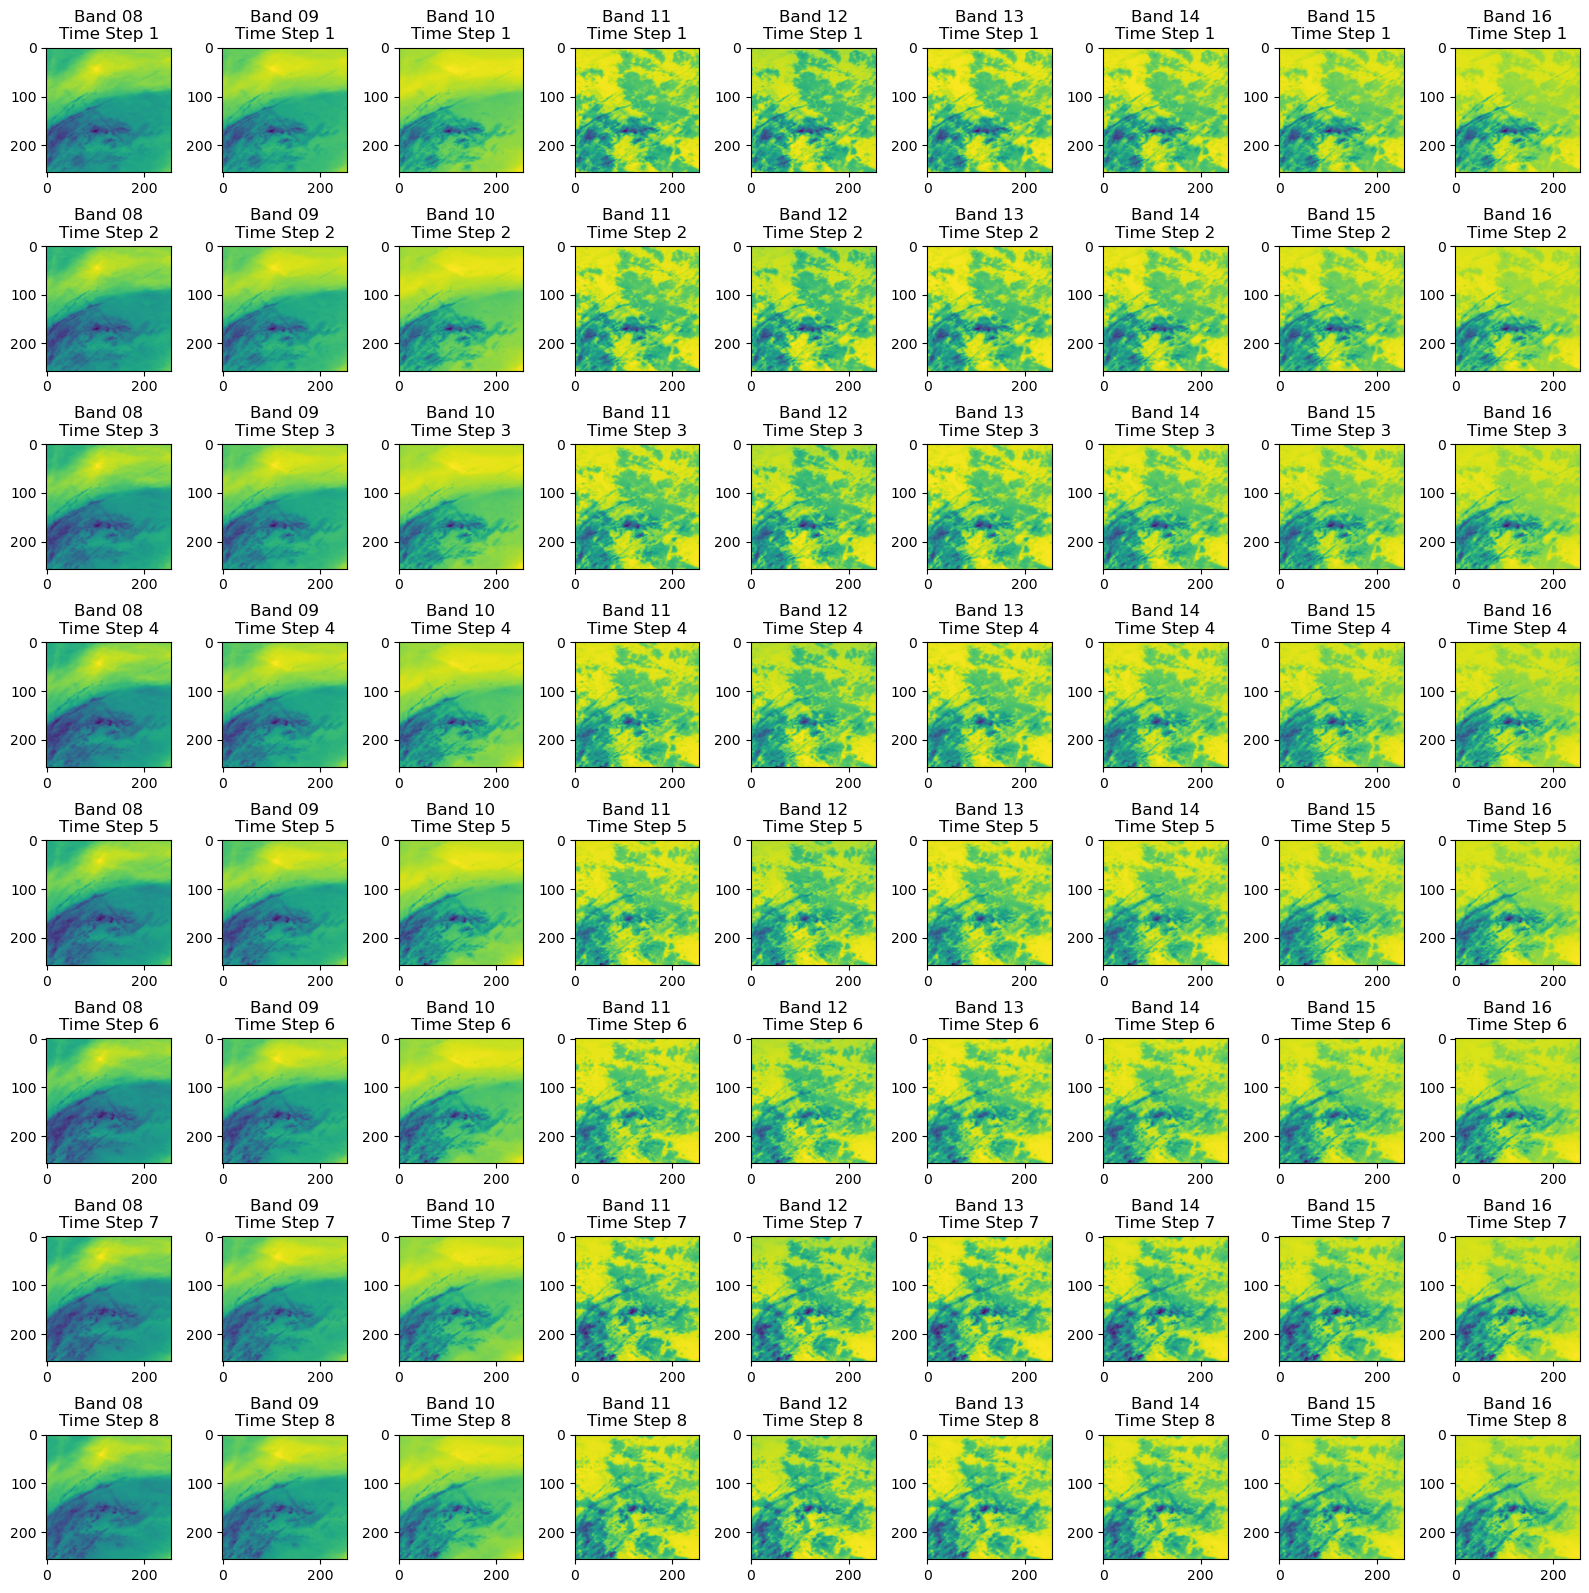

In [11]:
def plot_bands_over_time(sample_id, split_dir):
    """
    
    Adapted from:
    https://www.kaggle.com/code/pranavnadimpali/comprehensive-eda-submission
    
    Args: 
        sample_id(str): The id of the example i.e. '1000216489776414077'
        split_dir(str): The split directoryu i.e. 'test', 'train', 'val'
    """
    fig, axs = plt.subplots(8, len(ABI.bands), figsize=(16, 16)) 

    for band, j in ABI.bands.items():
        img = np.load(DATA_DIR + f"/{split_dir}/{sample_id}/band_{band}.npy")
        for i in range(8):
            axs[i, j].imshow(img[..., i]) 
            axs[i, j].set_title(f"Band {band}\nTime Step {i+1}") 

    plt.tight_layout()  
    plt.show()
    
plot_bands_over_time(sample_ids[3], 'train')

In [32]:
def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])

_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)

def get_ash_colors(sample_id, split_dir):
    """
    Based on bands: 11, 14, 15
    
    Args:
        sample_id(str): The id of the example i.e. '1000216489776414077'
        split_dir(str): The split directoryu i.e. 'test', 'train', 'val'
    """
    band15 = np.load(DATA_DIR + f"/{split_dir}/{sample_id}/band_15.npy")
    band14 = np.load(DATA_DIR + f"/{split_dir}/{sample_id}/band_14.npy")
    band11 = np.load(DATA_DIR + f"/{split_dir}/{sample_id}/band_11.npy")

    r = normalize_range(band15 - band14, _TDIFF_BOUNDS)
    g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
    b = normalize_range(band14, _T11_BOUNDS)
    ash_colors = np.clip(np.stack([r, g, b], axis=2), 0, 1)
    
    return ash_colors

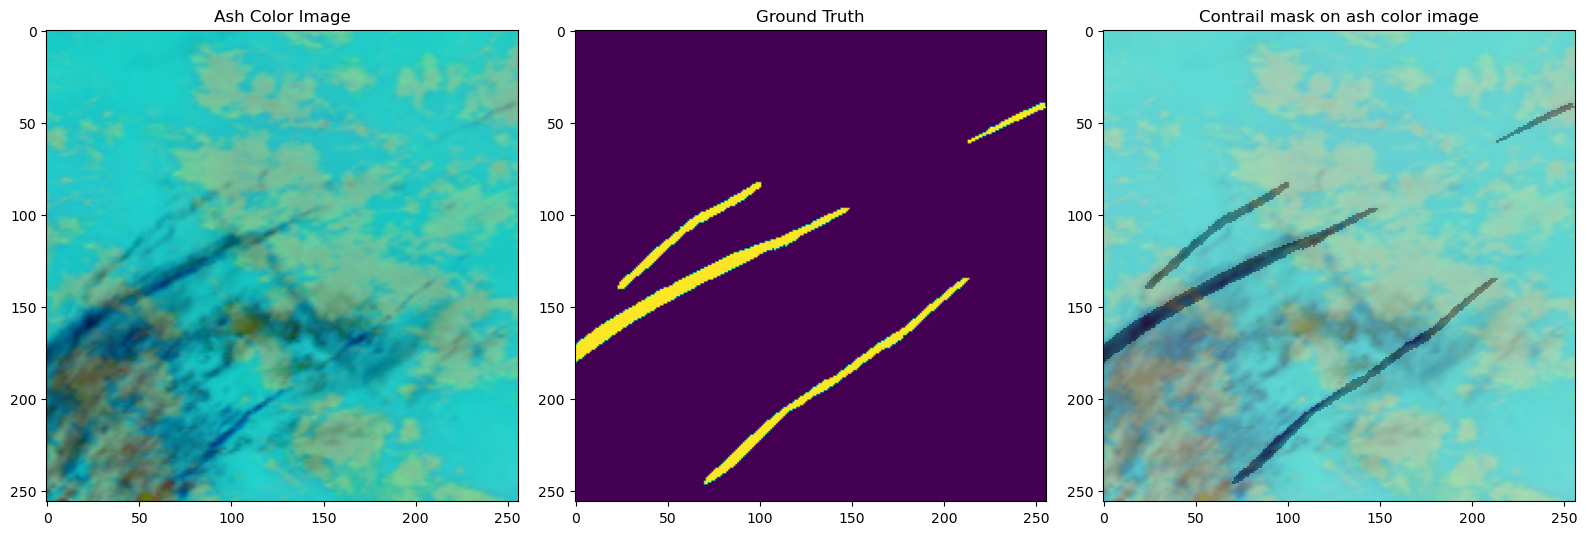

In [13]:
def plot_ash_colors(sample_id, split_dir, plot, time_step=4):

    masks_path = DATA_DIR + f"/{split_dir}/{sample_id}/human_pixel_masks.npy"

    ash_colors = get_ash_colors(sample_id, split_dir)

    img = ash_colors[..., time_step] # 5th image corresponds to ground truth
    ground_truth = np.load(masks_path)
    
    if plot:
        fig, axs = plt.subplots(1, 3, figsize=(16, 8))

        axs[0].imshow(img)
        axs[0].set_title("Ash Color Image")

        axs[1].imshow(ground_truth)
        axs[1].set_title("Ground Truth")

        axs[2].imshow(img)
        axs[2].imshow(ground_truth, cmap='Reds', alpha=.3, interpolation='none')
        axs[2].set_title('Contrail mask on ash color image')


        plt.tight_layout() 
        plt.show()

    return img
    
img = plot_ash_colors(sample_ids[3], 'train', True)

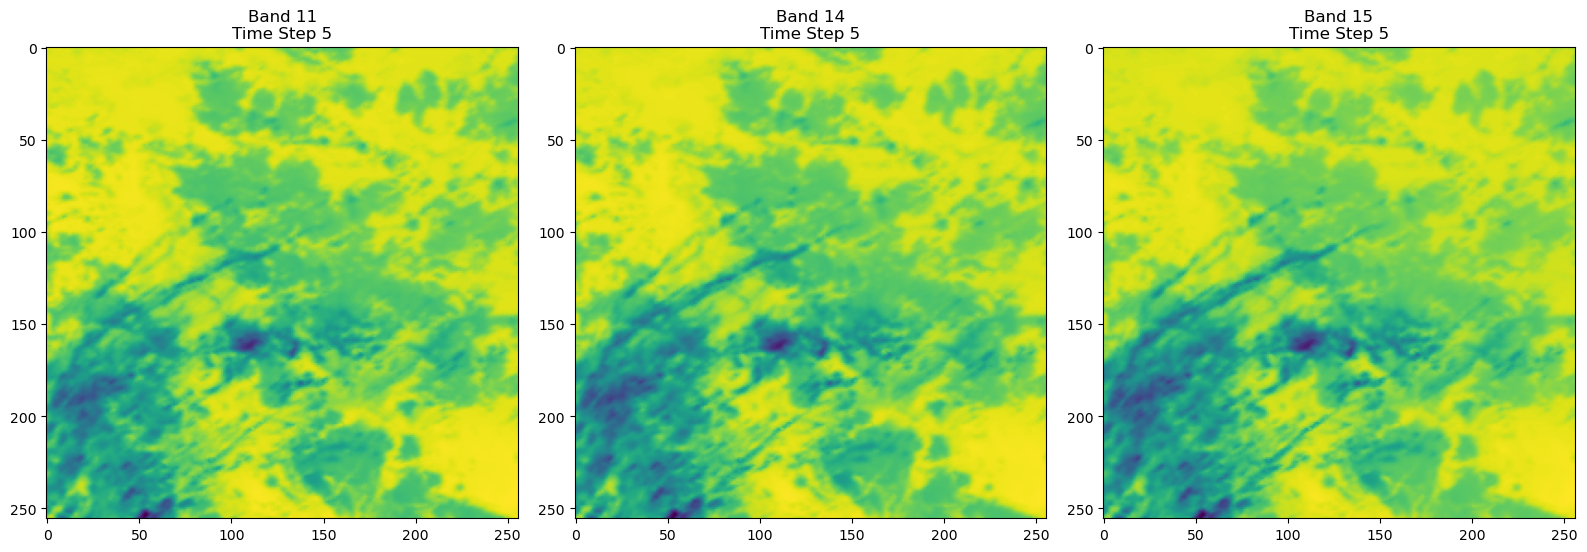

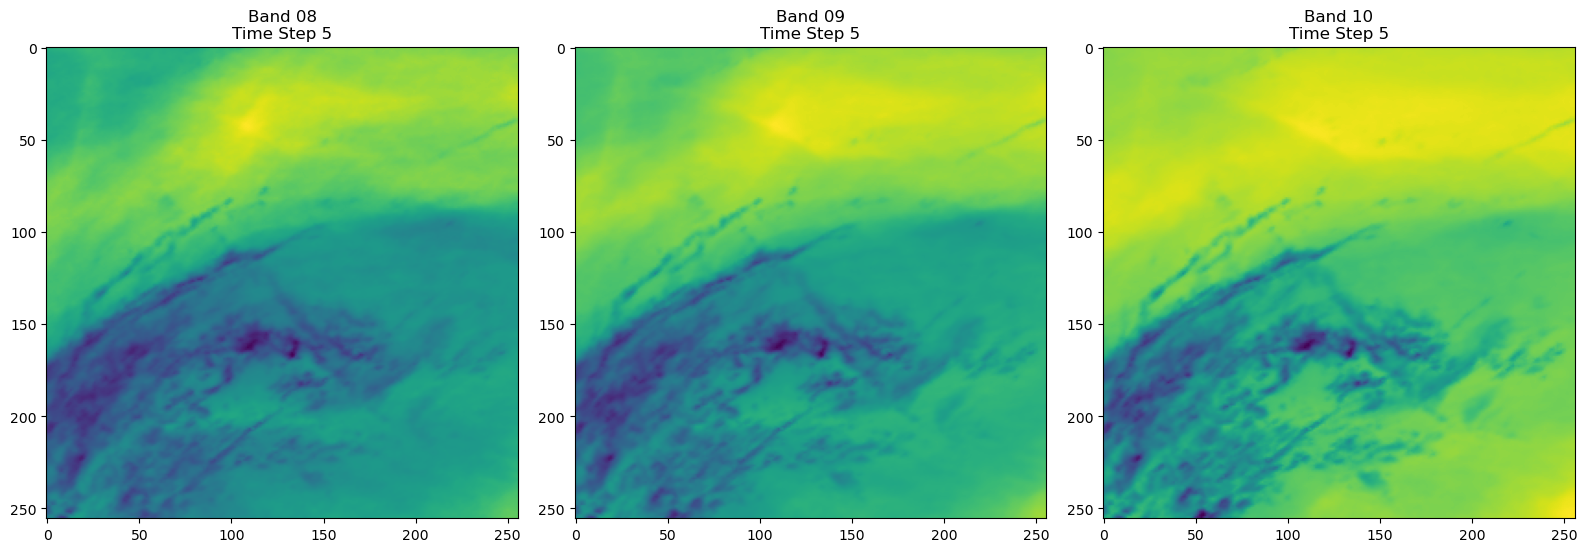

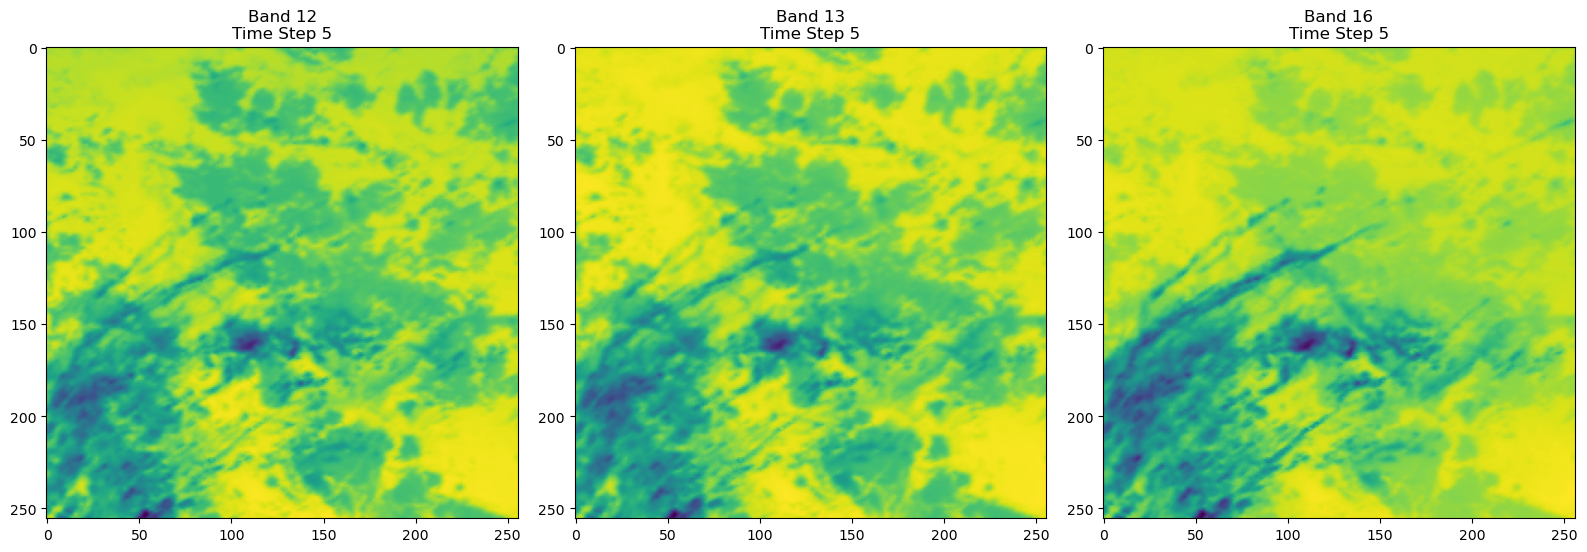

In [14]:
def plot_three_bands(sample_id, split_dir, bands, timestep=4):
    """
    
    Adapted from:
    https://www.kaggle.com/code/pranavnadimpali/comprehensive-eda-submission
    
    Args: 
        sample_id(str): The id of the example i.e. '1000216489776414077'
        split_dir(str): The split directoryu i.e. 'test', 'train', 'val'
    """
    fig, axs = plt.subplots(1, 3, figsize=(16, 16)) 

    for j, band in enumerate(bands):
        img = np.load(DATA_DIR + f"/{split_dir}/{sample_id}/band_{band}.npy")
        axs[j].imshow(img[..., timestep]) 
        axs[j].set_title(f"Band {band}\nTime Step {timestep+1}") 

    plt.tight_layout()  
    plt.show()
    
plot_three_bands(sample_ids[3], 'train', ['11', '14', '15'])
plot_three_bands(sample_ids[3], 'train', ['08', '09', '10'])
plot_three_bands(sample_ids[3], 'train', ['12', '13', '16'])

## Preprocessing

In [26]:
ash_path = pathlib.Path('ash_colors_images')
ash_path.mkdir(exist_ok=True, parents=True)

ash_path.resolve()

PosixPath('/kaggle/working/ash_color_images')

In [34]:
for sample_id in tqdm(train_ids[:5]):
    ash_colors = get_ash_colors(sample_id, 'train')

  0%|          | 0/5 [00:00<?, ?it/s]

In [35]:
ash_colors.shape

(256, 256, 3, 8)

## Build Model